# Multisensor fusion 

Author: Chen Lequn.
Created on 01 Feb 2023.

- Material： Maraging Steel 300
- Process: Robotic Llser-directed energy deposition
- Experiment number (single bead wall samples): 21-26
- Recorded data: position, veolocity, coaxial melt pool images, acoustic data
- Defect generated: keyhole pores, cracks, defect-free

### Notebook 3: benchmarking on audio dataset

- Performances for various deep learning models (VGG, GoogleNet, ResNet, LeNet, etc.) are evaluated and benchmarked on the coaxial melt pool image dataset.
- Best performance will guide subsequent multimodal fusion network development.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchaudio
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

import os
import argparse
from torch.utils.data import Subset
import pandas as pd
import numpy as np

# Scikit learn
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from audio_models import *
from multimodaldataset import MultimodalDataset, LDEDAudioDataset, LDEDVisionDataset
from utils import progress_bar

## plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
import seaborn as sns

Multimodal_dataset_PATH = os.path.join("C:\\Users\\Asus\\OneDrive_Chen1470\\OneDrive - Nanyang Technological University\\Dataset\\Multimodal_AM_monitoring\\LDED_Acoustic_Visual_Dataset")
CCD_Image_30Hz_path = os.path.join(Multimodal_dataset_PATH, 'Coaxial_CCD_images_30Hz')
Audio_segmented_30Hz_PATH = os.path.join(Multimodal_dataset_PATH, 'Audio_signal_all_30Hz')
Audio_raw_seg_PATH = os.path.join(Audio_segmented_30Hz_PATH, 'raw')
Audio_equalized_seg_PATH = os.path.join(Audio_segmented_30Hz_PATH, 'equalized')
Audio_bandpassed_seg_PATH = os.path.join(Audio_segmented_30Hz_PATH, 'bandpassed')
Audio_denoised_seg_PATH = os.path.join(Audio_segmented_30Hz_PATH, 'denoised')
AUDIO_DIR = Audio_denoised_seg_PATH
VISON_DIR = CCD_Image_30Hz_path

torch.manual_seed(0)

ANNOTATIONS_FILE = os.path.join(Multimodal_dataset_PATH, "vision_acoustic_label_v2.csv")

classes = ('Defect-free', 'Cracks', 'Keyhole pores', 'Laser-off', 'Laser-start')
SAMPLE_RATE = 44100
LEARNING_RATE = 0.0001
BATCH_SIZE = 16
EPOCHS = 10

### Utils functions

In [24]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'train_audio')
os.makedirs(IMAGE_PATH, exist_ok=True)

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

In [3]:
### Define Loss and Accuracy plot function
def loss_acc_plot(train_losses, valid_losses, train_accuracy, valid_accuracy, epochs_num, title, interval=20, yloss_limit1=0, yloss_limit2=1.5, yacc_limit1=0.4, yacc_limit2=1):
    fig, (ax1,ax2) = plt.subplots(nrows = 2, sharex = True, figsize=(7,8));
    # plt.title(title, fontsize = 20, y=1.05)
    # Loss plot
    ax1.plot(train_losses, 'darkorange', label = 'Train Loss', linewidth=2)
    ax1.plot(valid_losses, 'navy', label = 'Test Loss', linewidth=2)
    ax1.legend(loc =1, fontsize = 16)
    ax1.set_xlabel('Epochs', fontsize = 20)
    ax1.set_xticks(np.arange(0,epochs_num+1,interval))
    ax1.set_ylabel('Crossentropy Loss', fontsize = 20)
    ax1.set_ylim(yloss_limit1,yloss_limit2)
    ax1.set_title('Loss Curve', fontsize = 20, pad=12)
    ax1.xaxis.set_tick_params(labelsize=18)
    ax1.yaxis.set_tick_params(labelsize=18)
    
    # Accuracy plot
    ax2.plot(train_accuracy, 'darkorange', label = 'Train Accuracy', linewidth=2)
    ax2.plot(valid_accuracy, 'navy', label = 'Test Accuracy', linewidth=2)
    ax2.legend(loc =4, fontsize = 16)
    ax2.set_xlabel('Epochs', fontsize = 20)
    ax1.set_xticks(np.arange(0,epochs_num+1,interval))
    ax2.set_ylabel('Accuracy', fontsize =20)
    ax2.set_ylim(yacc_limit1,yacc_limit2)
    ax2.set_title('Accuracy Curve', fontsize =20, pad=12)
    ax2.xaxis.set_tick_params(labelsize=18)
    ax2.yaxis.set_tick_params(labelsize=18)
    ax1.grid(zorder=3, linestyle='--',linewidth=0.8, alpha=0.4, color = "k") #linestyle='--', color='r'
    ax2.grid(zorder=3, linestyle='--',linewidth=0.8, alpha=0.4, color = "k") #linestyle='--', color='r'
    # fig.suptitle(title, fontsize = 22, y=1.001)
    
    plt.tight_layout()

    
### Function to print out the model's loss and accuracy score
def xtest_loss_acc(modelname, X_test, y_test):
    
    model_score = modelname.evaluate(X_test, y_test, verbose =2)
    model_labels = modelname.metrics_names
    
    print(f"cnn {model_labels[0]}: {round(model_score[0] ,5)}")
    print(f"cnn {model_labels[1]}: {round(model_score[1] ,5)}")
    
    
### Define function to predict X_test, return y_pred & y_true and print the classification report
def class_report(modelname, X_test, y_test, le):
    ### predict the X_test
    # pred = modelname.predict_classes(X_test) # deprecated
    predict_x=modelname.predict(X_test) 
    pred=np.argmax(predict_x,axis=1)
    
    # compile predicted results
    y_true, y_pred = [], []
    classes = le.classes_
    
    for idx, preds in enumerate(pred):
        y_true.append(classes[np.argmax(y_test[idx])])
        y_pred.append(classes[preds])
    
    print(classification_report(y_true, y_pred,digits=4))
    return y_true, y_pred


### Function to plot confusion matrix

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(7,7))
    im_ratio = cm.shape[1]/cm.shape[0]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20, pad=12)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.3f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 fontsize = 16, 
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Ground Truth', fontsize=20, labelpad =12)
    plt.xlabel('Predicted', fontsize=20, labelpad =12)
    plt.xticks(fontsize=16,  rotation=45, ha='right')
    plt.yticks(fontsize=16)
    cbar = plt.colorbar(orientation="vertical", pad=0.1, ticks=[0.1, 0.4, 0.8], fraction=0.045*im_ratio)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_title('Accuracy',fontsize=16, pad = 12)
    plt.tight_layout()

    # plt.show()
    
def plot_confusion_matrix_sns(y_true, y_pred, classes):
    plt.figure(figsize=(10, 7))
    tick_marks = np.arange(len(classes))
    cm = confusion_matrix(y_true, y_pred)
    # convert to percentage and plot the confusion matrix
    cm_pct = cm.astype(float) / cm.sum(axis =1)[:,np.newaxis]
    sns.heatmap(cm_pct, annot=True, fmt='.3%', cmap='Blues', linewidths=2, linecolor='black') #cmap='Blues'
    plt.xticks(tick_marks, classes, horizontalalignment='center', rotation=70, fontsize=12)
    plt.yticks(tick_marks, classes, horizontalalignment="center", rotation=0, fontsize=12)

    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    
    
## Define function to get the confusion matrix and print out the plot as well
def conf_matrix(y_true, y_pred, le):
    cm = confusion_matrix(y_true, y_pred)
    
    # convert to percentage and plot the confusion matrix
    cm_pct = cm.astype(float) / cm.sum(axis =1)[:,np.newaxis]
    
    classes = le.classes_
    print(cm)
    plot_confusion_matrix(cm_pct, classes)

### Use GPU if possible

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Using cuda


### Annotation file

- Vision acoustic spatio-temporal registration has been done in our previous work. 
- Each frame (timestamp) corresponds to a robot TCP position.
- The duration for each frame is 0.033 seconds (sampling freqeuncy 30 Hz.)

In [5]:
annotations_df = pd.read_csv(ANNOTATIONS_FILE)
annotations_df.head()

,sample_index,audio_file_name,image_file_name,class_ID,class_name,class_v2,class_ID_2
0,0,Sample22_0000.wav,sample22_frame000000.jpg,3,Laser-off,No defect,0
1,1,Sample22_0001.wav,sample22_frame000001.jpg,3,Laser-off,No defect,0
2,2,Sample22_0002.wav,sample22_frame000002.jpg,3,Laser-off,No defect,0
3,3,Sample22_0003.wav,sample22_frame000003.jpg,3,Laser-off,No defect,0
4,4,Sample22_0004.wav,sample22_frame000004.jpg,3,Laser-off,No defect,0


In [6]:
# Get the labels and count the number of samples for each class
labels = annotations_df['class_ID_2'].values
label_counts = np.unique(labels, return_counts=True)[1]
print (label_counts)

[2358 3257]


### Basline accuracy
The baseline accuracy in this multi-class classificiation problem is **43%**, which is the accuracy of trivially predicting the most-frequent class (classify to the largest class– in other words).

In [7]:
### Get the percentage distribution of each category
round(annotations_df.groupby('class_v2')["class_v2"].count()/annotations_df.shape[0]*100, 1)

class_v2
Defect       58.0
No defect    42.0
Name: class_v2, dtype: float64

Saving figure dataset_2


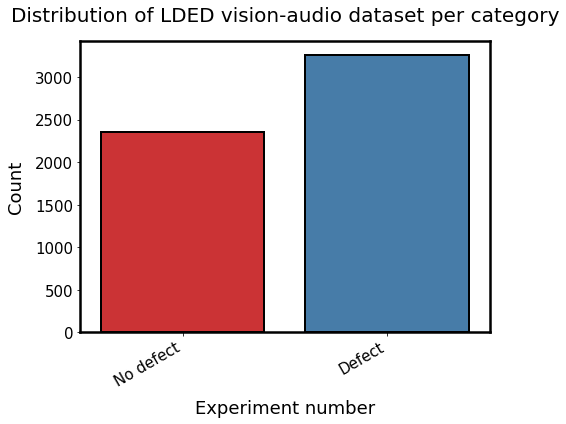

In [8]:
# sns.set(style="darkgrid")
plt.figure(figsize = (7,6))


ax = sns.countplot(x='class_v2', data = annotations_df, palette="Set1", linewidth=2,
                   edgecolor='k'); #palette='mako' 'Set2'
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha="right")
# ax = sns.countplot(y='label', data = df_dataset_denoised, palette="Set2");


ax.set_title('Distribution of LDED vision-audio dataset per category', fontsize = 20, pad=20);
ax.set_xlabel("Experiment number",fontsize=18, labelpad=10)
ax.set_ylabel("Count",fontsize=18, labelpad=10)
ax.tick_params(labelsize=15)

save_fig("dataset_2")

In [9]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n


## Define training, testing (evaluation) function

In [10]:
def train_single_epoch(model, epoch, trainloader, loss_fn, optimizer, device):
    '''
    Function for the training single epoch in the training loop
    '''
    print('\nEpoch: %d' % epoch)
    model.train() # training mode
    running_loss = 0
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        # calculate loss (forward pass)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        running_loss += loss.item() * inputs.size(0)
        # backpropagate error and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # record current progress
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Train Acc: %.3f%% (%d/%d)'
                    % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    
    acc = 100.*correct/total
    # print(f"loss: {loss.item()}")
    epoch_loss = running_loss / len(trainloader.dataset)
    # print("--------------epoch finished---------------")
    return model, optimizer, epoch_loss, acc

In [11]:
def test_single_epoch(model, epoch, testloader, loss_fn, device):
    model.eval() # evaluation mode
    global best_acc # for updating the best accuracy so far
    test_loss = 0
    correct = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            ## forward pass and calculate loss
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            running_loss += loss.item() *inputs.size(0)
            
            # record current progress
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            # progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Test Acc: %.3f%% (%d/%d)'
            #             % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc
    
    epoch_loss = test_loss / len(testloader.dataset)
    return model, epoch_loss, acc

In [12]:
def training_loop(model, loss_fn, optimizer, train_loader, valid_loader, epochs, scheduler, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    train_accuracy = []
    valid_accuracy = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss, train_acc = train_single_epoch(model, epoch, train_loader, loss_fn, optimizer, device)
        train_losses.append(train_loss)

        # validation
        # with torch.no_grad():
        model, valid_loss, valid_acc = test_single_epoch(model, epoch, valid_loader, loss_fn, device)
        valid_losses.append(valid_loss)

#         if epoch % print_every == (print_every - 1):
            
#             train_acc = get_accuracy(model, train_loader, device=device)
#             valid_acc = get_accuracy(model, valid_loader, device=device)
                
#             print(f'{datetime.now().time().replace(microsecond=0)} --- '
#                   f'Epoch: {epoch}\t'
#                   f'Train loss: {train_loss:.4f}\t'
#                   f'Valid loss: {valid_loss:.4f}\t'
#                   f'Train accuracy: {100 * train_acc:.2f}\t'
#                   f'Valid accuracy: {100 * valid_acc:.2f}')
        
        train_accuracy.append(train_acc)
        valid_accuracy.append(valid_acc)
        scheduler.step()
   
    return model, optimizer, (train_losses, valid_losses, train_accuracy, valid_accuracy)

## Preparing Dataset and DataLoader

In [13]:
#------ transformation------

# instantiating our dataset object and create data loader
mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=32
)

MFCCs = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE,n_mfcc=20)

C:\Users\Asus\anaconda3\envs\working_primary\lib\site-packages\torchaudio\functional\functional.py:594: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [14]:
#------ data loader------
# create the dataset for all samples
audiodataset = LDEDAudioDataset(annotations_df,
                                AUDIO_DIR,
                                # mel_spectrogram,
                                MFCCs,
                                # spectral_centroid,
                                SAMPLE_RATE,
                                device)
print ("length of the total dataset:" + str(len(audiodataset)))

length of the total dataset:5615


### Dealing with Imbalanced dataset: stratified sampling

- Split the data into train, validation, and test set
- Train and Val are used for hyperparameter tuning
- Train set will go through some data augmentation

In [15]:
# Split the data into train and validation datasets
# train_annotations, val_annotations = train_test_split(annotations_df, test_size=0.2)
# create the StratifiedShuffleSplit object
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

# split the indices of annotations into train and test sets
train_indices, test_indices = next(sss.split(annotations_df, labels))

# split the data into train and test sets
train_annotations = annotations_df.iloc[train_indices, :]
test_annotations = annotations_df.iloc[test_indices, :]

# Create the train and validation datasets
train_dataset = LDEDAudioDataset(train_annotations,
                                 AUDIO_DIR,
                                 MFCCs,
                                 SAMPLE_RATE,
                                 device=device)

val_dataset = LDEDAudioDataset(test_annotations,
                               AUDIO_DIR,
                               MFCCs,
                               SAMPLE_RATE,
                               device=device)

In [16]:
# test_annotations

### Create DataLoader using the dataset

In [17]:
# # Create train and val dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
# test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("length of the train dataset:" +  str(len(train_dataloader.dataset)))
print("length of the val dataset:" +  str(len(val_dataloader.dataset)))
# print("length of the test dataset:" +  str(len(test_dataloader.dataset)))

length of the train dataset:4492
length of the val dataset:1123


## Training the model

In [18]:
resume = False
start_epoch = 0
best_acc = 0

==> Building model..
--- Using CUDA ---

Epoch: 0
 [================================================================>]  Step: 44ms | Tot: 5s270ms | Loss: 0.700 | Train Acc: 58.927% (2647/449 281/281 
Saving..

Epoch: 1
 [================================================================>]  Step: 19ms | Tot: 6s392ms | Loss: 0.511 | Train Acc: 79.185% (3557/449 281/281 
Saving..

Epoch: 2
 [================================================================>]  Step: 18ms | Tot: 6s668ms | Loss: 0.479 | Train Acc: 82.524% (3707/449 281/281 

Epoch: 3
 [================================================================>]  Step: 18ms | Tot: 6s594ms | Loss: 0.475 | Train Acc: 83.259% (3740/449 281/281 

Epoch: 4
 [================================================================>]  Step: 20ms | Tot: 6s544ms | Loss: 0.469 | Train Acc: 83.949% (3771/449 281/281 

Epoch: 5
 [================================================================>]  Step: 20ms | Tot: 6s474ms | Loss: 0.471 | Train Acc: 83.638% (

C:\Users\Asus\AppData\Local\Temp\ipykernel_14508\2211512462.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


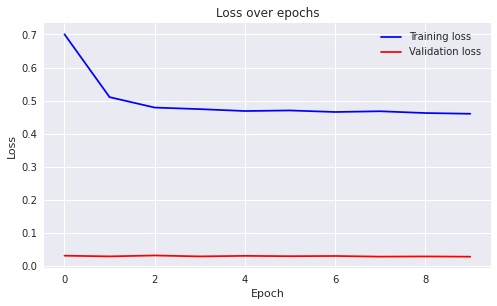

In [19]:
# -----Model---------------
print('==> Building model..')

net = MFCCCNN() 

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    print ("--- Using CUDA ---")

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

loss_fn = nn.CrossEntropyLoss()
# Note: weight_decay in pytorch is L2 regularization
# optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE,
#                     momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# for epoch in range(start_epoch, start_epoch+EPOCHS):
    # train_single_epoch(net, epoch, train_dataloader, loss_fn, optimizer, device)
    # test_single_epoch(net, epoch, val_dataloader, loss_fn, device)
    # scheduler.step()

model, optimizer, (train_losses, valid_losses, train_accuracy, valid_accuracy) = training_loop(net, loss_fn, optimizer, train_dataloader, val_dataloader, EPOCHS, scheduler, device)

In [26]:
valid_accuracy

[82.3686553873553,
 84.50578806767587,
 79.34105075690115,
 84.14959928762244,
 81.38913624220837,
 82.9919857524488,
 82.45770258236865,
 85.39626001780944,
 84.59483526268923,
 85.6634016028495]

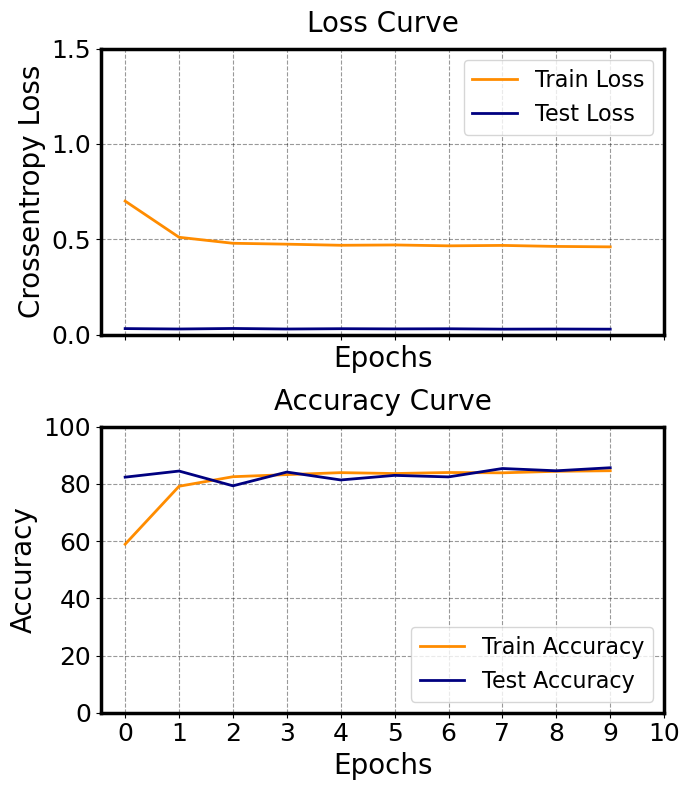

In [27]:
loss_acc_plot(train_losses, valid_losses, train_accuracy, valid_accuracy, 10, "Initial Training",
              interval=1, yloss_limit1=0, yloss_limit2=1.5, yacc_limit1=0, yacc_limit2=100)